# Projeto 3: modelo de Lorenz

Vamos explorar o sistema de equações

$$ \dot{x} = - \sigma x + \sigma y $$
$$ \dot{y} = rx - y - xz $$
$$ \dot{z} = -bz + xy $$

este é o modelo de Lorenz, primeira demonstração conhecida do caos determinístico.

Para começar, faço as importações apropriadas, a função de derivadas, `modelo_lorenz`, e a função que gera soluções, `integra_lorenz`:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint
from scipy.optimize import curve_fit
from scipy.signal import argrelmax
%matplotlib inline

In [2]:
def modelo_lorenz(xyz, t, r, σ=10, b=8/3):
    x,y,z = xyz
    u = -σ*x + σ*y
    v = r*x - y - x*z
    w = -b*z + x*y
    return [u, v, w]


# Condições iniciais padrão
inicial_padrao = np.array([0, 1, 0])

# r: parâmetro da equação de Lorenz
# inicial: valores iniciais de x,y,z
# Δt, t0, tf: intervalo de tempo, tempo inicial e tempo final
# params: parâmetros adicionais (σ e b)
def integra_lorenz(r, inicial=inicial_padrao, Δt=0.0025, t0=0, tf=40, *params):
    t = np.arange(t0, tf+Δt, Δt)
    args = (r,) + params
    sol = odeint(modelo_lorenz, inicial, t, args)
    x, y, z = sol.T
    return np.vstack((x, y, z, t))

## Problema 1

Primeiro calculo e grafico soluções para os seis valores de $r$ pedidos.

In [3]:
# Calcula as soluções nas condições iniciais padrão
# para t indo de 0 até 40, r na lista abaixo:
valores_r = [1, 7, 15, 20, 35, 50]
solucoes_dic1 = {}
for r in valores_r:
    sol = integra_lorenz(r)
    solucoes_dic1[r] = sol

/home/solano/.local/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


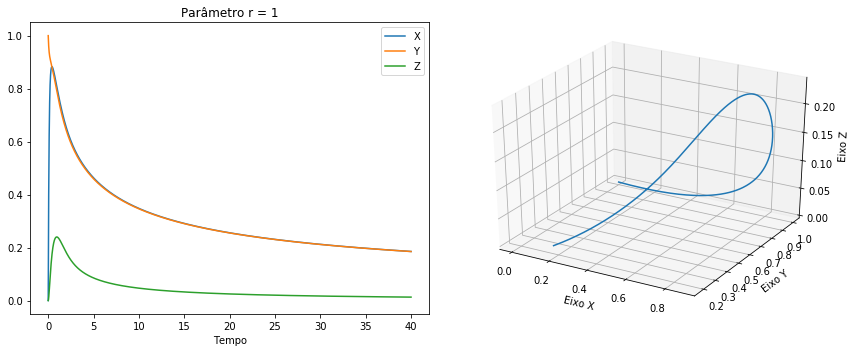

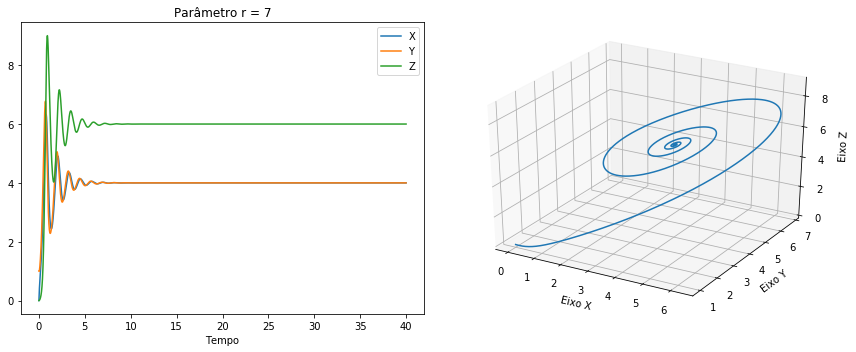

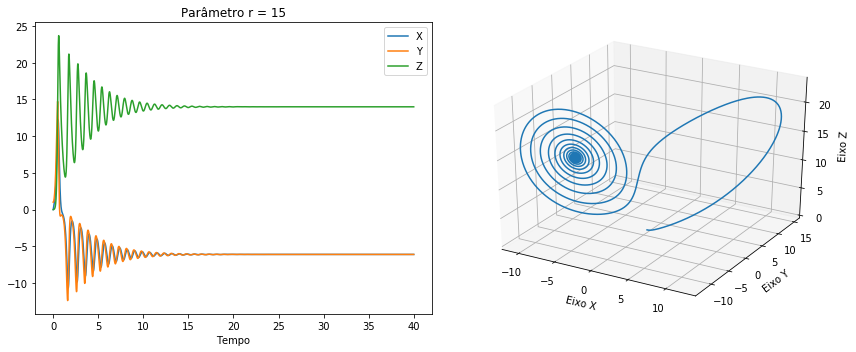

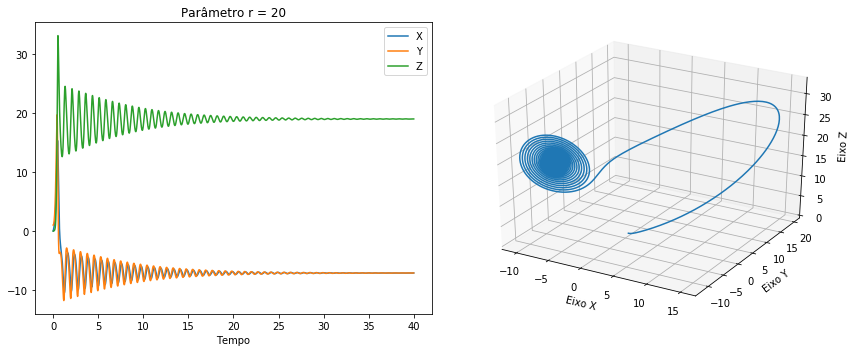

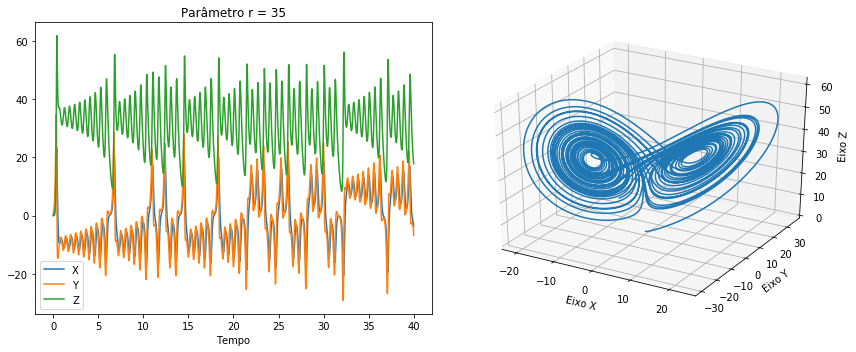

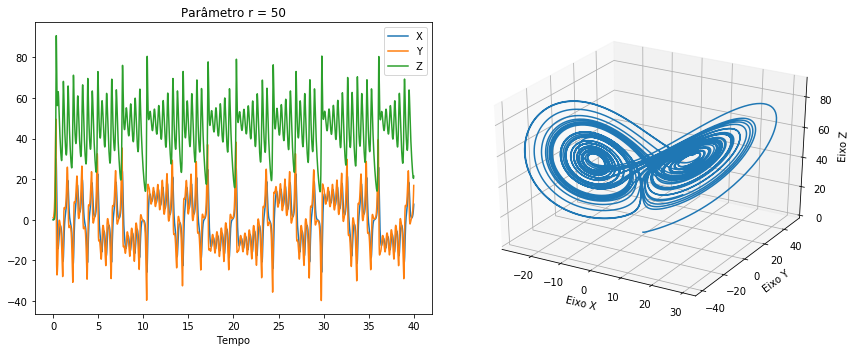

In [4]:
# Grafica coordenadas em função do tempo
def grafica_coord(ax, x, y, z, t):
    ax.plot(t, x, label='X')
    ax.plot(t, y, label='Y')
    ax.plot(t, z, label='Z')
    ax.set_xlabel('Tempo')
    ax.legend()

# Grafica a trajetória em 3D
def grafica_traj(ax3d, x, y, z):
    ax3d.plot(x, y, z)
    ax3d.set_xlabel('Eixo X')
    ax3d.set_ylabel('Eixo Y')
    ax3d.set_zlabel('Eixo Z')

for r, sol in solucoes_dic1.items():
    x, y, z, t = sol

    fig = plt.figure(figsize=(12,5))
    
    ax1 = fig.add_subplot(121)
    grafica_coord(ax1, x, y, z, t)
    
    ax2 = fig.add_subplot(122, projection='3d')
    grafica_traj(ax2, x, y, z)
    
    ax1.set_title('Parâmetro r = {}'.format(r))
    fig.tight_layout()
    fig.show()

### Discussão:

Com $r = 1$, não se observa oscilação, e todas as variáveis, após um curto transiente, caem exponencialmente.

Com $r = 7$ começa a haver oscilação e o sistema é atraído para um ponto.

Com $r = 15$ e $r = 20$, o sistema dá a volta nesse primeiro ponto (transiente) e entra num segundo atrator, espiralando para dentro.

Com $r = 35$ e $r = 50$ há dois pontos especiais repulsores. O sistema espirala em torno de cada ponto (esquerda e direita) individualmente, e muda de lado de maneira imprevisível quando chega perto do centro, o que se vê claramente nos saltos das variáveis $X$ e $Y$ no gráfico. A cada salto, chega perto de um dos pontos repulsores, e então espirala para fora, chegando novamente perto do centro e realizando outro salto.

## Problema 2

Agora calculo os expoentes de Lyapunov para cada caso, usando a classe auxiliar `SolDif`. Os resultados estão exibido nos gráficos abaixo (onde $\lambda$ denota expoente de Lyapunov).

In [5]:
# Classe que encapsula um par de soluções com condições iniciais próximas.
# As propriedades `sol` e `sol_perturb` são as soluções e `lyapunov` é o
# expoente de Lyapunov. As propriedades são avaliadas "preguiçosamente".

class SolDif:
    _sol = None
    _sol_perturb = None
    _lyapunov = None
    
    def __init__(self, r, δ=1e-2, inicial=inicial_padrao, **params):
        self.params = params   # parâmetros adicionais para integra_lorenz
        self.r = r 
        self.inicial = inicial
        self.δ = δ
        self.inicial_perturb = [inicial[0], inicial[1]+δ, inicial[2]]
    
    def get_sol(self):
        if np.all(self._sol == None):
            self._sol = integra_lorenz(self.r, inicial=self.inicial, **self.params)
        return self._sol
    
    def get_sol_perturb(self):
        if np.all(self._sol_perturb == None):
            self._sol_perturb = integra_lorenz(self.r, inicial=self.inicial_perturb, **self.params)
        return self._sol_perturb
    
    sol = property(get_sol, lambda x: None)
    sol_perturb = property(get_sol_perturb, lambda x: None)
    
    def get_lyapunov(self):
        if self._lyapunov == None:
            _, y1, _, t = soldif.sol
            _, y2, _, _ = soldif.sol_perturb
            dif = np.abs(y2-y1)
            
            (λ,), ((λ_err,),) = curve_fit(lambda t, λ: self.δ*np.exp(λ*t),
                                         t, dif, [0])
            self._lyapunov = λ
        return self._lyapunov
    
    lyapunov = property(get_lyapunov, lambda x: None)


# Inicializa soluções com valores de δ e intervalos de tempo
# escolhidos para obter comportamento aproximadamente exponencial.
solucoes_dic2 = {}
valores_δ = [1e-6, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6]
valores_tf = [0.50, 0.45, 0.35, 0.30, 0.25, 0.20]
for r, δ, tf in zip(valores_r, valores_δ, valores_tf): 
    solucoes_dic2[r] = SolDif(r, δ, tf=tf, Δt=0.0025)

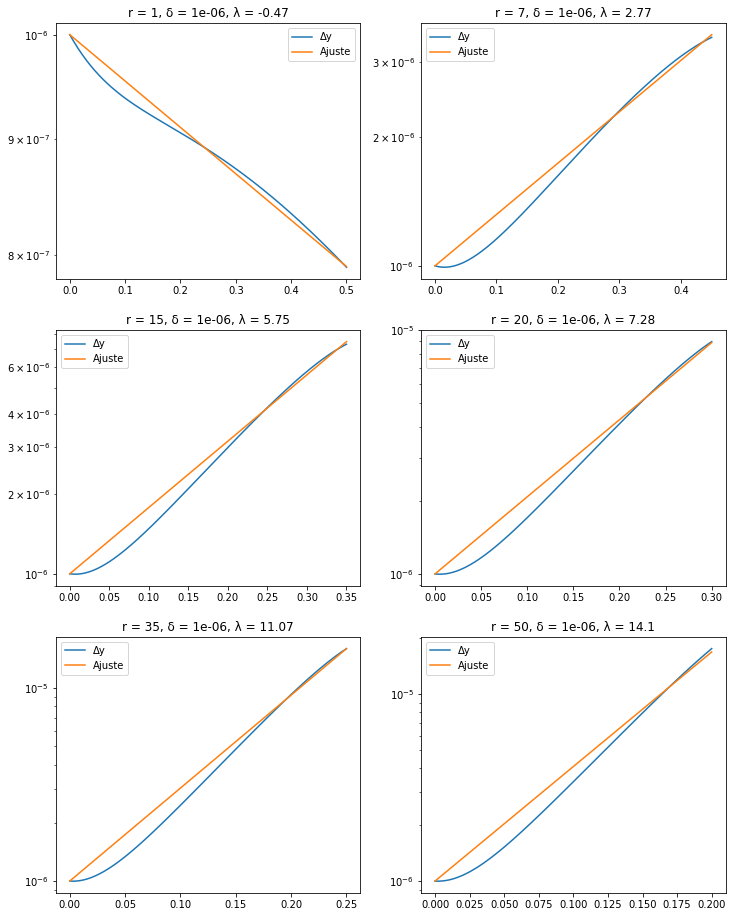

In [6]:
# Grafica o comportamento (aproximadamente) exponencial
# da diferença Δy em cada caso, assim como o expoente
# de Lyapunov.
fig, axarr = plt.subplots(figsize=(12,16), ncols=2, nrows=3)
for (r, soldif), ax in zip(solucoes_dic2.items(), axarr.flat):
    _, y1, _, t = soldif.sol
    _, y2, _, _ = soldif.sol_perturb
    
    λ = round(soldif.lyapunov, 2)
    
    #plt.figure()
    #ax = plt.axes(yscale='log')
    ax.set_yscale('log')
    ax.plot(t, np.abs(y2-y1), label='Δy')
    ax.plot(t, soldif.δ*np.exp(λ*t), label='Ajuste')
    ax.set_title(f'r = {r}, δ = {soldif.δ}, λ = {λ}')
    ax.legend()
plt.show()

### Discussão:

Os intervalos de tempo foram ajustados manualmente para vermos comportamento aproximadamente exponencial nos gráficos (aproximadamente linear em semilog). Os coeficientes de Lyapunov, na faixa considerada, aumentam com o parâmetro $r$. Em particular, são positivos (indicando sensibilidade a condições iniciais) para todos os valores testados exceto o menor ($r = 1$), em que soluções com condições iniciais próximas convergem. Esta tendência mostra que o aumento do parâmetro $r$ leva ao caos porque aumenta a sensibilidade a condições iniciais.

Interessantemente, todos os $\Delta y$ brevemente diminuem no início da simulação. O comportamento exponencial imediato (para $t$ muito pequeno) é sempre um decaimento, mas isto parece ser um artefato da simulação.

## Problema 3

Agora calculo máximos locais do sistema com $r$ variável para produzir diagramas de bifurcação. O cálculo é feito pela função `calcula_bifurc` e os gráficos, pela função `grafica_bifurc`.

**SIMULAÇÕES DEMORADAS**

In [97]:
# Integra 600 sistemas diferentes com valores de r entre 1 e 200.
# Armazena os máximos locais de x, y e z para t entre 30 e 80.

def calcula_bifurc(r_arr, t_corte=30, t_final=80):
    maximos_dic = {}
    for r in r_arr:
        # Simula, remove transientes
        x, y, z, t = integra_lorenz(r, tf=t_final)
        x, y, z = x[t>=t_corte], y[t>=t_corte], z[t>=t_corte]

        # Calcula máximos e cria dicionário com valores para graficar
        (maxarg_x,), (maxarg_y,), (maxarg_z,) = map(argrelmax, [x, y, z])
        max_x, max_y, max_z = x[maxarg_x], y[maxarg_y], z[maxarg_z]
        rx, ry, rz = np.full_like(max_x, r), np.full_like(max_y, r), np.full_like(max_z, r)
        maximos_dic[r] = {'x': (rx, max_x),
                          'y': (ry, max_y),
                          'z': (rz, max_z)}
    return maximos_dic

r_arr = np.linspace(1, 200, 600)
maximos_dic1 = calcula_bifurc(r_arr)

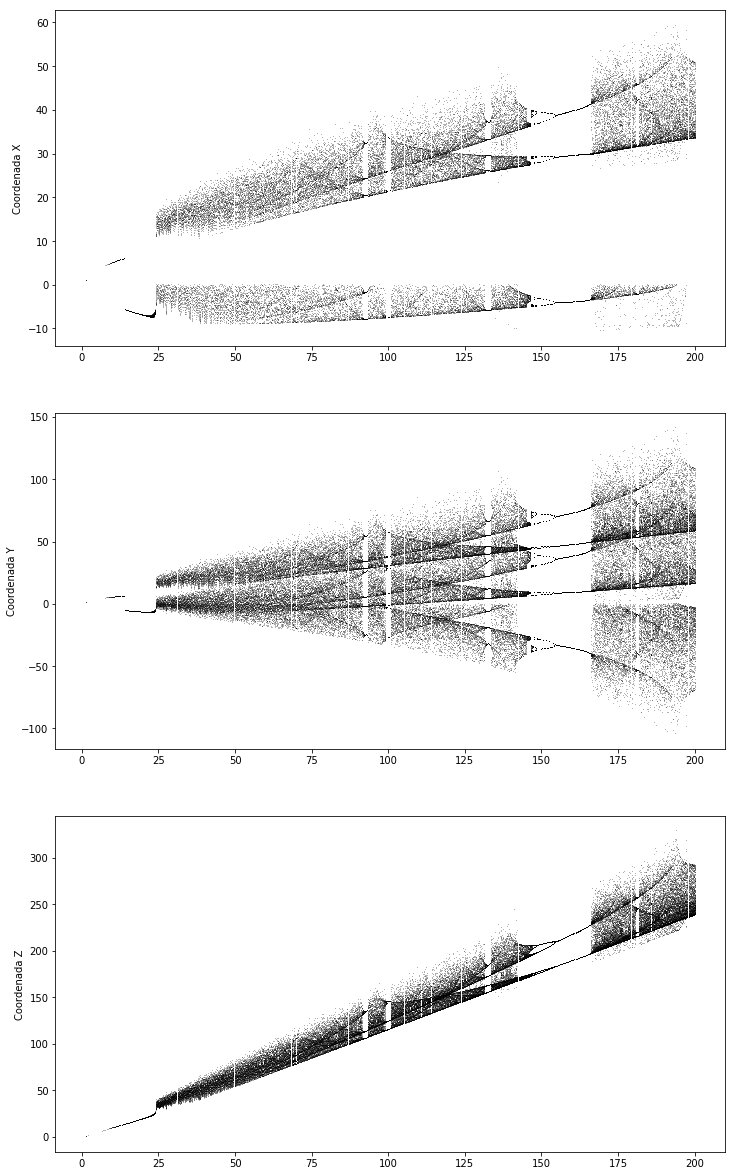

In [98]:
# Faz gráficos de bifurcação com os dados de maximos_dic.
def grafica_bifurc(maximos_dic, rmin=1, rmax=200, fig=None, fmt=',k', alpha=0.3, **params):
    if fig == None:
        fig = plt.figure(figsize=(12,21))
    
    axx = fig.add_subplot(311, ylabel='Coordenada X')
    axy = fig.add_subplot(312, ylabel='Coordenada Y')
    axz = fig.add_subplot(313, ylabel='Coordenada Z')
    
    for r, dic in maximos_dic.items():
        if rmin <= r and r <= rmax:
            axx.plot(dic['x'][0], dic['x'][1], fmt, alpha=alpha, **params)
            axy.plot(dic['y'][0], dic['y'][1], fmt, alpha=alpha, **params)
            axz.plot(dic['z'][0], dic['z'][1], fmt, alpha=alpha, **params)

    return fig

# Grafica tudo
grafica_bifurc(maximos_dic1).show()

### Discussão:

Os diagramas mostram que o sistema tem comportamento caótico para quase todos os valores de $r$ considerados, exceto antes de $r \approx 25$, em algumas faixas curtas de valores e na faixa longa entre aproximadamente $r = 150$ e $r = 170$. Nessas faixas, em vez de uma distribuição de pontos vemos curvas contínuas, indicando que o sistema é não caótico (e provavelmente periódico).

Para $r \approx 15$, onde não há caos, observa-se um salto nas coordenadas X e Y que corresponde à mudança qualitativa de comportamento vista nas simulações do problema 1, quando fomos de $r=7$ para $r=15$: o que era um centro atrator vira um repulsor e o sistema "pula" para um atrator ao lado.

Em torno de $r \approx 150$, onde também não há caos, novamente vemos saltos nas coordenadas X e Y, mas dessa vez também observa-se duplicações de período quando $r$ diminui na coordenada Z. Veja abaixo.

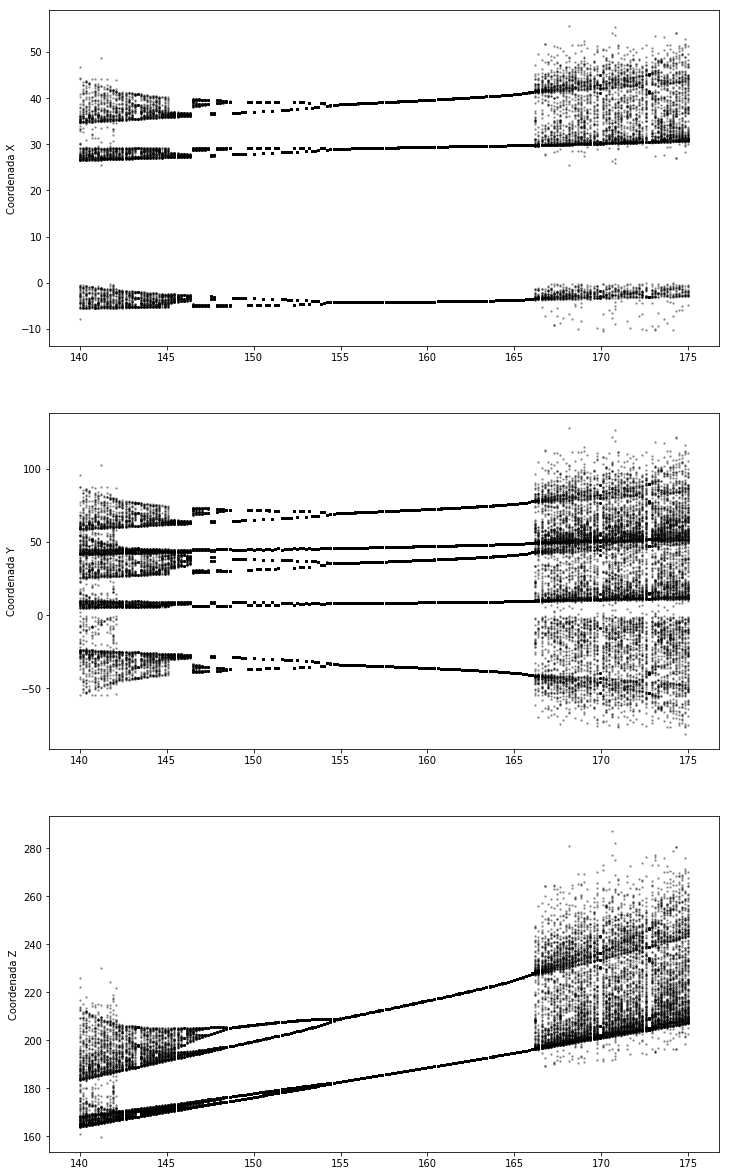

In [100]:
# Calcula com mais precisão e grafica o diagrama no intervalo [140, 175]
maximos_dic2 = calcula_bifurc(np.linspace(140, 175, 200))
grafica_bifurc(maximos_dic2, 140, 175, fmt='ok', markersize=1.5).show()